In [1880]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from QLearningBoltzmann import QLearningBoltzmann as boltz

In [1881]:
#f_csma = "../../SOMAC-ML/data/_BKP/29092018/csma/round2/backlog_file.npy"
#f_tdma = "../../SOMAC-ML/data/_BKP/29092018/tdma/round2/backlog_file.npy"

f_csma = "../../SOMAC-ML/data/06102018/run3/3/csma/backlog_file.npy"
f_tdma = "../../SOMAC-ML/data/06102018/run3/3/tdma/backlog_file.npy"

#f_csma = "../../SOMAC-ML/data/06102018/run4/5/csma/backlog_file.npy"
#f_tdma = "../../SOMAC-ML/data/06102018/run4/5/tdma/backlog_file.npy"

d_csma = np.load(f_csma, encoding = "latin1").item()
d_tdma = np.load(f_tdma, encoding = "latin1").item()

n = np.min([len(d_csma), len(d_tdma)]) - 10

t_csma = np.array([d_csma[t]["metrics"][0, 1] for t in range(n)])
t_tdma = np.array([d_tdma[t]["metrics"][0, 1] for t in range(n)])

In [1882]:
logging.basicConfig(filename="/Users/andre.gomes/Temp/out.log", level = logging.INFO)

prot   = 1
somac  = boltz(prot)
metric = {}
t      = 0
dt     = -1

decision = prot
backlog  = {}

In [1883]:
def calc_reward(curr, prev):
    # Positive reward
    if curr > prev and curr <= 1.2 * prev:
        reward = 0.
        
    elif curr > 1.2 * prev and curr <= 1.4 * prev:
        reward = 1.
        
    elif curr > 1.4 * prev and curr <= 1.6 * prev:
        reward = 2.
        
    elif curr > 1.6 * prev and curr <= 1.8 * prev:
        reward = 3.
        
    elif curr > 1.8 * prev and curr <= 2.0 * prev:
        reward = 4.
        
    elif curr > 2.0 * prev:
        reward = 5.

    # Negative reward
    elif prev > curr and prev <= 1.2 * curr:
        reward = 0.

    elif prev > 1.2 * curr and prev <= 1.4 * curr:
        reward = -1.
        
    elif prev > 1.4 * curr and prev <= 1.6 * curr:
        reward = -2.
        
    elif prev > 1.6 * curr and prev <= 1.8 * curr:
        reward = -3.
        
    elif prev > 1.8 * curr and prev <= 2.0 * curr:
        reward = -4.
        
    elif prev > 2.0 * curr:
        reward = -5.

    else:
        reward = 0.

    return reward

while t < n:
    metric[t] = t_csma[t] if prot == 0 else t_tdma[t]
    print("Metrics = {}".format(metric[t]))
    print("t = {}, dt = {}".format(t, dt))
    
    backlog[t] = prot
    
    if dt > 1:
        if dt == 2:
            reward = calc_reward(metric[t], metric[t-2])
        elif dt == 3:
            reward = calc_reward(metric[t], metric[t-3])
        else:
            reward = calc_reward(metric[t], metric[t-1]) * 0.01
            #reward = reward if reward == 0 else reward ** -dt
            
        somac.update_qtable(reward, np.sqrt(dt))
        
        if dt == 2 and reward > 0:
            decision = somac.decision(prot, keep = True)
        elif dt == 2 and reward < 0.:
            decision = somac.decision(prot, force_switch = True)
        else:
            decision = somac.decision(prot, keep = False)
        
        if decision != prot:
            dt = 0
    else:
        print("MAC prot was switched recently. No switch now")
    
    
    t = t + 1
    dt = dt + 1
    
    print("Protocol: {}".format(
        "CSMA" if prot == 0 else "TDMA"
    ))
    
    prot = decision
    
    print("Decision: {}".format(
        "CSMA" if prot == 0 else "TDMA"
    ))
    
    print("\n=============================\n")

Metrics = 1.0500000398606062
t = 0, dt = -1
MAC prot was switched recently. No switch now
Protocol: TDMA
Decision: TDMA


Metrics = 2.2499994914978743
t = 1, dt = 0
MAC prot was switched recently. No switch now
Protocol: TDMA
Decision: TDMA


Metrics = 2.2666664998978376
t = 2, dt = 1
MAC prot was switched recently. No switch now
Protocol: TDMA
Decision: TDMA


Metrics = 2.3402299880981445
t = 3, dt = 2
Protocol: TDMA
Decision: CSMA


Metrics = 0.6005749776959419
t = 4, dt = 1
MAC prot was switched recently. No switch now
Protocol: CSMA
Decision: CSMA


Metrics = 0.9500000178813934
t = 5, dt = 2
Protocol: CSMA
Decision: TDMA


Metrics = 4.749999970197678
t = 6, dt = 1
MAC prot was switched recently. No switch now
Protocol: TDMA
Decision: TDMA


Metrics = 6.083333373069763
t = 7, dt = 2
Protocol: TDMA
Decision: TDMA


Metrics = 6.133333412930369
t = 8, dt = 3
Protocol: TDMA
Decision: TDMA


Metrics = 6.350000500679016
t = 9, dt = 4
Protocol: TDMA
Decision: TDMA


Metrics = 6.53333306312

In [1884]:
n_csma  = 0
n_tdma  = 0
n_somac = 0
n_changes = 0

for t in range(n):
    if t_csma[t] >= .9 * t_tdma[t]:
        n_csma = n_csma + 1
        
        if backlog[t] == 0:
            n_somac = n_somac + 1

    if t_tdma[t] >= .9 * t_csma[t]:
        n_tdma = n_tdma + 1
        
        if backlog[t] == 1:
            n_somac = n_somac + 1
        
for t in range(1, n, 1):
    if backlog[t-1] != backlog[t]:
        n_changes = n_changes + 1
        
print("CSMA count = {}%, TDMA count = {}%".format(
    round(n_csma * 1. / n, 2),
    round(n_tdma * 1. / n, 2)
))
print("Taxa de acerto = {}%".format(round(n_somac * 1. / n, 2)))
print("No. de trocas = {}".format(n_changes))
print("n = {}".format(n))

print("Desempenho médio:\nCSMA = {}, TDMA = {}, SOMAC = {}".format(
    round(np.mean(t_csma), 2),
    round(np.mean(t_tdma), 2),
    round(np.mean([metric[t] for t in range(n)]), 2)
))

norm = np.max([
    round(np.mean(t_csma), 2),
    round(np.mean(t_tdma), 2),
    round(np.mean([metric[t] for t in range(n)]), 2)
])

print("Desempenho médio (%):\nCSMA = {}, TDMA = {}, SOMAC = {}".format(
    round(np.mean(t_csma) / norm, 2),
    round(np.mean(t_tdma) / norm, 2),
    round(np.mean([metric[t] for t in range(n)]) / norm, 2)
))

CSMA count = 0.28%, TDMA count = 0.77%
Taxa de acerto = 0.87%
No. de trocas = 7
n = 53
Desempenho médio:
CSMA = 8.9, TDMA = 11.7, SOMAC = 12.82
Desempenho médio (%):
CSMA = 0.69, TDMA = 0.91, SOMAC = 1.0


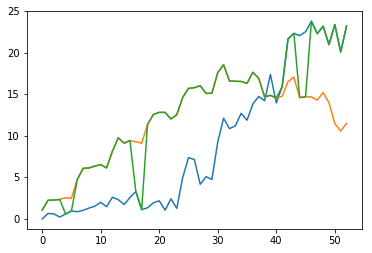

In [1885]:
t = np.arange(n)

plt.plot(
    t, t_csma,
    t, t_tdma,
    t, [metric[i] for i in range(n)]
)

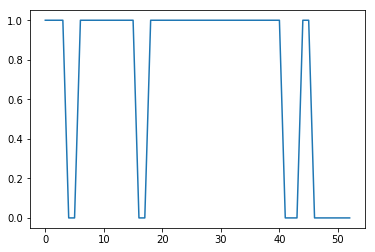

In [1886]:
plt.plot(t, [backlog[i] for i in range(n)])